# Numerical Optimization HW4 (1103)
## Multivariate Optimization
### 20211108 Donghyuk Jung  

Multivariate Optimization for smooth function
- The method of steppest descent
- Newton's method
- Quasi-Newton's method : SR1, BFGS

In this notebook, we will optimize three functions

$f(x,y)=(x+2y-6)^2+(2x+y-6)^2\\$
$f(x,y)=50(y-x^2)^2+(1-x)^2\\$
$f(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$

---
### Iteration formular

$x_{k+1}\coloneqq x_k+\alpha_kp_k$ where $\alpha_k$ is step length and $p_k$ is search direction

__Method of Steppest Descent__ $p_k=-\nabla f(x_k)$

__Newton's Method__ $p_k=-(\nabla^2f(x_k))^{-1}\nabla f(x_k)$

__Quasi Newton's Method__ $p_k=-\bold{B}_k^{-1}\nabla f(x_k)$ where $\bold{B}_k \approx (\nabla^2f(x_k)) $

---
# Implementation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.tri as tri 
import math as m
import time as t
from tabulate import tabulate

### Define Function

In [2]:
def f_1(p):
    x, y = p[0][0], p[1][0]
    return (x+2*y-6)**2+(2*x+y-6)**2
def f_2(p):
    x, y = p[0][0], p[1][0] 
    return 50*(y-x**2)**2+(1-x)**2
def f_3(p):
    x, y = p[0][0], p[1][0]
    return (1.5-x+x*y)*2+(2.25-x+x*(y**2))**2+(2.625-x+x*(y**3))**2

### Define Plotting Function

In [3]:
def plotContour(f, rangeX=(0, 0), rangeY=(0, 0), grid=(0, 0)):
    x = np.arange(*rangeX, 0.01)
    y = np.arange(*rangeY, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = f(([X], [Y]))
    plt.figure(figsize=grid)
    cp = plt.contour(X, Y, Z, levels=np.linspace(
        Z.reshape(-1, 1).min(), Z.reshape(-1, 1).max(), 120), linewidths=0.1)  # plt.colorbar(cp)


def plotLine(x1, x2, color="black"):
    plt.plot([x1[0], x2[0]], [x1[1], x2[1]], color, linewidth=.8)


def plotPoint(x, color="black"):
    plt.plot([x[0]], [x[1]], color, marker='o', markersize=4)


def plotText(x, str=None):
    plt.plot([x[0]], [x[1]], "black", marker='o', markersize=4)
    if str != None:
        plt.text(x[0]+.03, x[1]+.03, str, fontsize=20)
    else:
        plt.text(x[0]+.03, x[1]+.03, "(%.3f, %.3f)" % x, fontsize=20)


def resultsInTable(x, f):
    print("\n%s results at (%.2f, %.2f) " % (f.__name__, x.T[0][0], x.T[0][1]))
    if f == f_1:
        print("minimum value of f1 is 0.0 at (2,2)")
    elif f == f_2:
        print("minimum value of f2 is 0.0 at (1,1)")
    elif f == f_3:
        print("minimum value of f3 is 6.16298e-32 at (3,0.5)")
    plotText(x, "x0")
    sd = steepestDescent(x.copy(), f, color="purple")
    ne = newton(x.copy(), f, color="green")
    sr1 = quasiNewtonSR1(x.copy(), f, color="red")
    bfgs = quasiNewtonBFGS(x.copy(), f, color="blue")
    print(tabulate([["S.D", *sd], ["Newton", *ne], ["SR1", *sr1], ["BFGS", *bfgs]],headers=["f(x)", "x", "iter", "time"], tablefmt="github", floatfmt=(".5f",".5f")))
    return
def printVal(xk, f, iter, start):
    return "%.8f" % f(xk), "(%.8f, %.8f)" % (xk.T[0][0], xk.T[0][1]), iter, "%4.2f"%((t.time()-start)*1000)

### Gradient and Hessian Implementation

In [4]:

def grad(p, f):
    dx = np.array([[[-h], [0]], [[h], [0]]])
    dy = np.array([[[0], [-h]], [[0], [h]]])
    g1 = (f(p+dx[1])-f(p+dx[0]))/(2*h)
    g2 = (f(p+dy[1])-f(p+dy[0]))/(2*h)
    g = np.array([[g1], [g2]])
    return g


def hessian(p, f):
    dx = np.array([[[-h], [0]], [[h], [0]]])
    dy = np.array([[[0], [-h]], [[0], [h]]])
    H11 = (f(p+2*dx[1])-2*f(p)+f(p+2*dx[0]))/(4*h**2)
    H12 = (f(p+dx[1]+dy[1])-f(p+dx[1]+dy[0]) -
           f(p+dx[0]+dy[1])+f(p+dx[0]+dy[0]))/(4*h**2)
    H21 = H12
    H22 = (f(p+2*dx[1])-2*f(p)+f(p+2*dx[0]))/(4*h**2)
    H = np.array([[H11, H12], [H21, H22]])
    return H


### Backtracking Method for step length

In [5]:
def stepLength(x0, p, f): # Use backtrakingMethod 
    a0 = 3
    r = 0.9
    c = 0.6
    a = a0 
    while True:
        if f(x0+a*p) > a*c*np.dot(grad(x0, f).T, p)+f(x0): 
            a *= r
        else: 
            break
    return a

### Method of Steepest descent

In [6]:
def steepestDescent(x0, f, color="black"):
    iter, start = 0, t.time()
    xk = x0
    while True:
        pk = -grad(xk, f)
        pk /= np.linalg.norm(pk)
        sk = stepLength(xk, pk, f)*pk
        plotLine(xk, xk+sk, color)
        plotPoint((xk.T[0][0], xk.T[0][1]), color)

        xk += sk

        iter += 1
        if np.linalg.norm(sk) <= eps:
            plt.plot(xk.T[0][0], xk.T[0][1], color, marker='o', markersize=6)
            break
    return printVal(xk, f, iter, start)


### Newton's Method

In [7]:
def newton(x0, f, color="black"): 
    iter, start = 0, t.time()
    xk = x0
    while True:
        dfx = grad(xk, f)
        Hk = hessian(xk, f)
        pk = -np.matmul(np.linalg.inv(Hk), dfx) 
        pk /= np.linalg.norm(pk)
        sk = stepLength(xk, pk, f)*pk 
        plotLine(xk, xk+sk, color) 
        plotPoint((xk.T[0][0], xk.T[0][1]), color)
        xk += sk
        iter += 1

        if np.linalg.norm(sk) <= eps:
            plt.plot(xk.T[0][0], xk.T[0][1], color, marker='o', markersize=6)
            break
    return printVal(xk, f, iter, start)

### Quasi-Newton's Method with rank 1 : SR1 Method

In [8]:
def quasiNewtonSR1(x0, f, color="black"):
    iter, start = 0, t.time()
    I = np.array([[1, 0], [0, 1]])
    sk, yk, Hk = np.array([[1, 0]]).T, np.array([[1, 0]]).T, I 
    pk = np.array([[1, 0]]).T
    xk = x0 
    while True:
        dfx = grad(xk, f)
        pk = -np.matmul(Hk, dfx) 
        pk /= np.linalg.norm(pk)
        sk = stepLength(xk, pk, f)*pk 
        plotLine(xk, xk+sk, color) 
        plotPoint((xk.T[0][0], xk.T[0][1]), color)
        xk += sk
        yk = grad(xk, f)-dfx
        Hk = Hk+(sk-np.matmul(Hk, yk))*(sk-np.matmul(Hk, yk)).T / (np.dot((sk-np.matmul(Hk, yk)).T, yk))
        iter += 1
        if np.linalg.norm(sk) <= eps:
            plt.plot(xk.T[0][0], xk.T[0][1], color, marker='o', markersize=6)
            break
    return printVal(xk, f, iter, start)

### Quasi-Newton's Method with rank 2 : BFGS

In [9]:
def quasiNewtonBFGS(x, f, color="black"):
    iter, start = 0, t.time()
    I = np.array([[1, 0], [0, 1]])
    sk, yk, Hk = np.array([[1, 0]]).T, np.array([[1, 0]]).T, I 
    pk = np.array([[1, 0]]).T
    xk = x 
    while True:
        dfx = grad(xk, f)
        pk = -np.matmul(Hk, dfx)
        pk /= np.linalg.norm(pk)

        sk = stepLength(xk, pk, f)*pk 
        plotLine(xk, xk+sk, color) 
        plotPoint((xk.T[0][0], xk.T[0][1]), color) 
        xk += sk
        yk = grad(xk, f)-dfx

        rk = 1/(np.dot(yk.T, sk))
        Hk = (I-rk*sk*yk.T)*Hk*(I-rk*yk*sk.T)+rk*sk*sk.T

        iter += 1
        if np.linalg.norm(sk) <= eps:
            plt.plot(xk.T[0][0], xk.T[0][1], color, marker='o', markersize=6)
        break
    return printVal(xk, f, iter, start)

---
## Results
### Optimize result at point $x_0=(1.2,1.2)$


f_1 results at (1.20, 1.20) 
minimum value of f1 is 0.0 at (2,2)
|        |    f(x) | x                        |   iter |   time |
|--------|---------|--------------------------|--------|--------|
| S.D    | 0.00000 | (1.99999769, 1.99999769) |      9 |  37.4  |
| Newton | 0.00000 | (1.99999769, 1.99999769) |      9 |  37.23 |
| SR1    | 0.00000 | (1.99999769, 1.99999769) |      9 |  30.57 |
| BFGS   | 0.72632 | (1.79912352, 1.79912352) |      1 |   1.41 |

f_2 results at (1.20, 1.20) 
minimum value of f2 is 0.0 at (1,1)
|        |    f(x) | x                        |   iter |   time |
|--------|---------|--------------------------|--------|--------|
| S.D    | 0.00001 | (1.00257874, 1.00518998) |    141 | 752.91 |
| Newton | 0.00000 | (1.00065820, 1.00132666) |     83 | 417.3  |
| SR1    | 0.00223 | (1.02552932, 1.04609425) |      7 |  35.49 |
| BFGS   | 0.25134 | (1.13755014, 1.22584132) |      1 |   3.11 |

f_3 results at (1.20, 1.20) 
minimum value of f3 is 6.16298e-32 at (3,0.5)


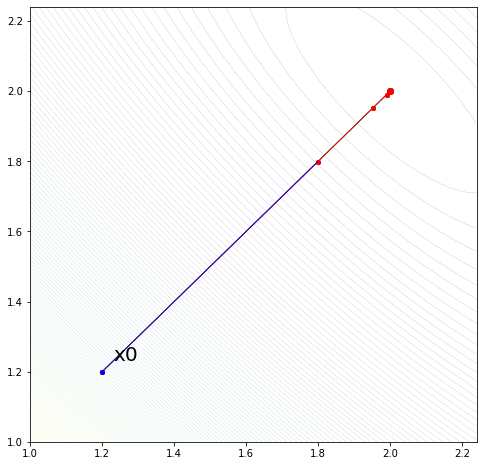

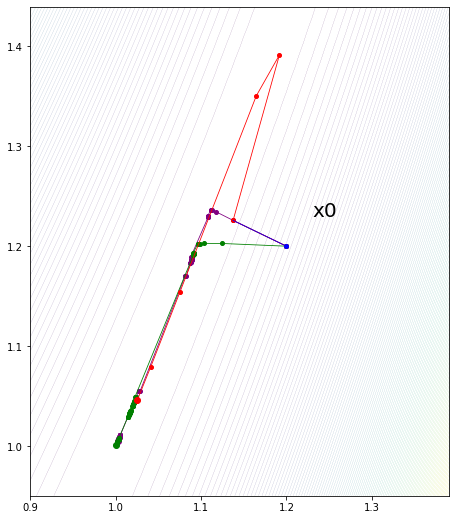

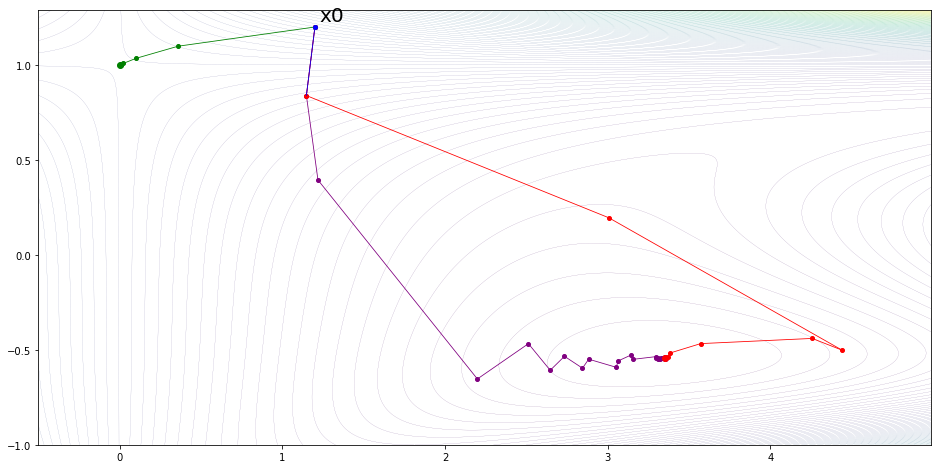

In [10]:
h = 1e-7 
eps = 1e-5
x0 = np.array([[1.2, 1.2]]).T
plotContour(f_1, rangeX=(1, 2.25), rangeY=(1, 2.25), grid=(8, 8)) 
resultsInTable(x0.copy(), f_1)
plotContour(f_2, rangeX=(0.9, 1.4), rangeY=(0.95, 1.45), grid=(7.5, 9)) 
resultsInTable(x0.copy(), f_2)
plotContour(f_3, rangeX=(-0.5, 5.0), rangeY=(-1, 1.3), grid=(16, 8)) 
resultsInTable(x0.copy(), f_3)

### $f(x,y)=(x+2y-6)^2+(2x+y-6)^2\\$ with initial point $x_0=(1.7,1.2)


f_1 results at (1.70, 1.20) 
minimum value of f1 is 0.0 at (2,2)
|        |    f(x) | x                        |   iter |   time |
|--------|---------|--------------------------|--------|--------|
| S.D    | 0.00000 | (2.00002634, 1.99997339) |     23 |  86.45 |
| Newton | 0.00000 | (1.99999892, 1.99999842) |      9 |  30.16 |
| SR1    | 0.00000 | (1.99999762, 1.99999738) |      9 |  30.12 |
| BFGS   | 0.33703 | (2.11417451, 1.65823563) |      1 |   1.47 |


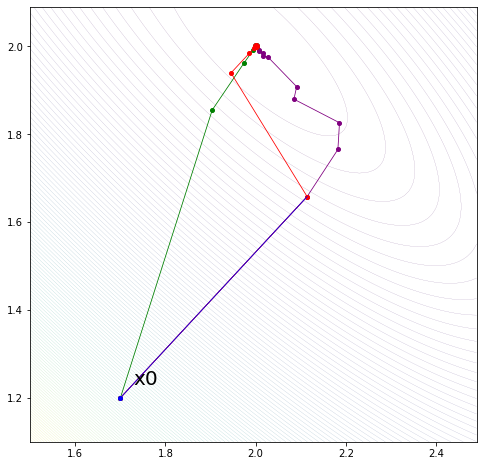

In [11]:
x0 = np.array([[1.7, 1.2]]).T
plotContour(f_1, rangeX=(1.5, 2.5), rangeY=(1.1, 2.1), grid=(8, 8))
resultsInTable(x0.copy(), f_1)


f_2 results at (-2.00, 2.00) 
minimum value of f2 is 0.0 at (1,1)
|        |     f(x) | x                         |   iter |   time |
|--------|----------|---------------------------|--------|--------|
| S.D    |  0.00001 | (1.00263885, 1.00531048)  |    175 | 785.67 |
| Newton |  2.33778 | (-0.51228736, 0.29430263) |     12 | 181.97 |
| SR1    |  6.23975 | (-1.47807752, 2.14024307) |      7 |  28.5  |
| BFGS   | 26.31410 | (-1.64600549, 2.08783983) |      1 |   2    |


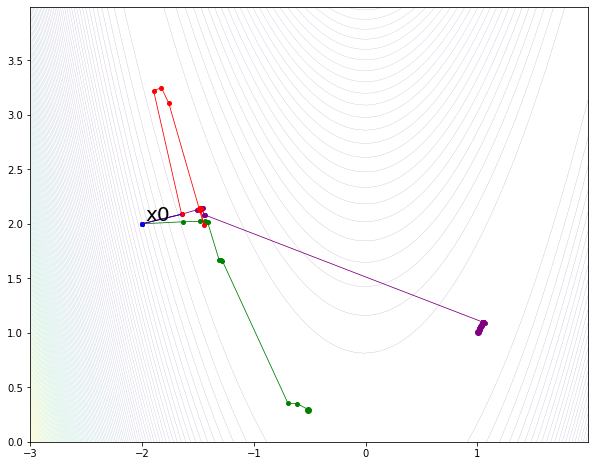

In [12]:
x0 = np.array([[-2.0, 2.0]]).T
plotContour(f_2, rangeX=(-3, 2), rangeY=(0, 4), grid=(10, 8)) 
resultsInTable(x0.copy(), f_2)



f_3 results at (1.00, 0.00) 
minimum value of f3 is 6.16298e-32 at (3,0.5)
|        |     f(x) | x                         |   iter |   time |
|--------|----------|---------------------------|--------|--------|
| S.D    | -5.73452 | (3.35000389, -0.54358946) |     25 |  98.77 |
| Newton | -2.32565 | (2.19349702, -0.79654014) |      2 |  16.6  |
| SR1    | -5.73452 | (3.35001809, -0.54359066) |     10 |  34.8  |
| BFGS   | -5.63581 | (3.11762251, -0.54648323) |      1 |   1.05 |


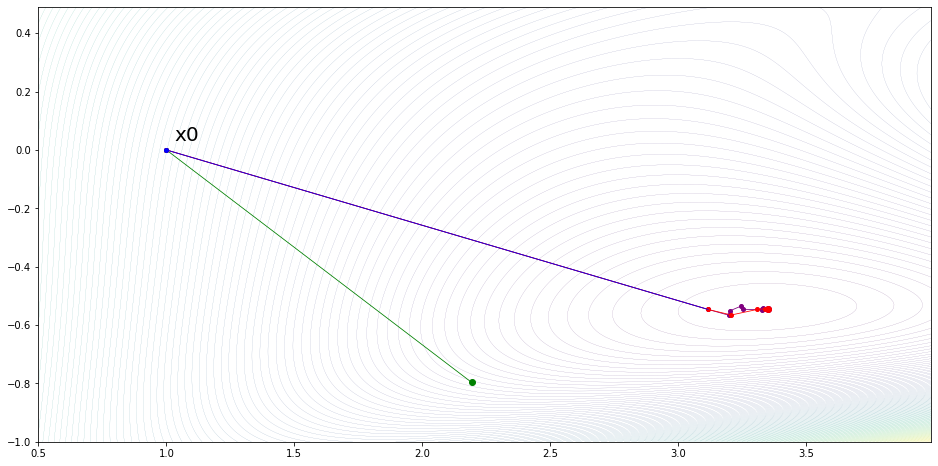

In [13]:
x0 = np.array([[1.0, 0.0]]).T
plotContour(f_3, rangeX=(0.5, 4), rangeY=(-1, 0.5), grid=(16, 8)) 
resultsInTable(x0.copy(), f_3)